Added Quantization

In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
from scipy.stats import skew
import random

In [3]:
def seed_all(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
seed_all(42)

In [4]:
# Hyperparameters
batch_size = 128
epochs =3
beta = 0.95
# The beta defined here = (1 - delta(t)/Tau)
# Here delta(t) is the clk period
# Tau = Time constant = RC
# This is the approximation of beta = exp(-delta(t)/Tau)
num_steps = 25
no_of_conductance_levels = 20

In [5]:
# Perform learning over cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST("./../data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST("./../data", train=False, download=True, transform=transform)

In [7]:
# Loading the training and test data
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
data_it = data_it.view(batch_size, -1)
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.shape)
#spike_data = (spike_data.view(num_steps,batch_size, -1))

torch.Size([25, 128, 784])


In [9]:
# Here we are creating a single hidden layer NN, with 150 nodes
class Net(nn.Module):
    def __init__(self, num_hidden_layer = 150):
        super().__init__()

        # Initialize layers
        self.linear_1 = nn.Linear(in_features=784,out_features=num_hidden_layer,bias=False)
        self.lif1 = snn.Leaky(beta=beta,reset_mechanism= "zero")
        self.linear_2 = nn.Linear(in_features=num_hidden_layer, out_features=10, bias=False)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        spk1_rec = []

        x = spikegen.rate(x, num_steps=num_steps)

        for step in range(num_steps):
            cur1 = self.linear_1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            cur2 = self.linear_2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0) , torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
num_hidden_layer = 150
model = Net(num_hidden_layer=num_hidden_layer).to(device)
next(model.parameters()).is_cuda


True

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def accuracy():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, label in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            label = label.to(device)

            # Test set forward pass
            _, test_spk, test_mem = model(images.view(batch_size, -1))
            n_samples += label.size(0)
            _, idx = test_spk.sum(dim=0).max(1)
            n_correct+= (label == idx).sum().item()
            return(n_correct/n_samples * 100)

In [12]:
%%time
stashed_global = []
stashed_lin1_wt_dict = {}
stashed_lin1_bias_dict = {}
stashed_lin2_wt_dict = {}
threshold = 11
all_neurons_joined = 0
accuracy_plot = []
univ = [i for i in range(num_hidden_layer)]
#spk1_freq_temp = torch.empty((batch_size,num_hidden_layer)).to(device)
n_total_steps = len(train_loader)
for epoch_iter in range(epochs):
    spk1_freq_temp = torch.empty((batch_size,num_hidden_layer)).to(device)

    if(epoch_iter == (epochs-1)):
        print("Joined all the stashed nodes")
        for i in stashed_global:
            assert model.linear_2.weight[:,i].any() == False
            assert model.linear_1.weight[i,:].any() == False
            #assert model.linear_1.bias[i] == 0
        print("Assertions Passed")
        with torch.no_grad():
            for key in stashed_lin1_wt_dict:
                model.linear_1.weight[key,:] = stashed_lin1_wt_dict[key]
                #model.linear_1.bias[key] = stashed_lin1_bias_dict[key]
                model.linear_2.weight[:,key] = stashed_lin2_wt_dict[key]

    for i,(data, target) in enumerate(train_loader):
        x = data.to(device)
        y = target.to(device)
        spk1_rec, spk_rec, mem_rec = model(x.view(batch_size, -1))
        spk1_rec = torch.sum(spk1_rec, 0)
        spk1_freq_temp = torch.cat((spk1_freq_temp, spk1_rec))
        loss_val = torch.zeros((1),device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], y)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        # for p in model.linear_1.weight:
        #     p.data.clamp_(0)

        if((i+1) % 30 == 0):
            accuracy_plot.append(accuracy())
            if(epoch_iter != (epochs-1)):
                all_neurons_joined+=1

        if (i+1) % 50 == 0:
             print (f'Epoch [{epoch_iter+1}/{epochs}], Step[{i+1}/{(n_total_steps)}], Loss: {loss_val.item():.4f}')
             print("-------------------------")
        
        if((epoch_iter<(epochs-1)) and (i+1) % 300 == 0):
            stashed = []
            print("Accuracy before stashing", accuracy())
            for j in univ:
                if(spk1_freq_temp[-1,j]>threshold):
                    stashed.append(j)
                    stashed_global.append(j)
            for k in stashed:
                stashed_lin1_wt_dict[k] =model.linear_1.weight[k,:].clone().detach()
                #stashed_lin1_bias_dict[k] = model.linear_1.bias[k].clone().detach()
                stashed_lin2_wt_dict[k] = model.linear_2.weight[:,k].clone().detach()
            
            print("Node stashed", stashed)
            print("-------------------------")
            univ = [i for i in univ if i not in stashed]
        
        if(epoch_iter<(epochs-1)):
            for k in stashed_global:
                with torch.no_grad():
                    model.linear_1.weight[k,:] = 0
                    #model.linear_1.bias[k] = 0
                    model.linear_2.weight[:,k] = 0
            
            if((i+1) % 300 == 0):
                print("Accuracy after_stashing is", accuracy())
        
print("Total nodes stashed", len(stashed_global))
        

Epoch [1/3], Step[50/468], Loss: 24.1632
-------------------------
Epoch [1/3], Step[100/468], Loss: 15.4672
-------------------------
Epoch [1/3], Step[150/468], Loss: 12.1740
-------------------------
Epoch [1/3], Step[200/468], Loss: 10.6770
-------------------------
Epoch [1/3], Step[250/468], Loss: 10.8403
-------------------------
Epoch [1/3], Step[300/468], Loss: 8.4391
-------------------------
Accuracy before stashing 90.625
Node stashed [0, 5, 6, 7, 8, 13, 14, 16, 23, 24, 25, 28, 31, 35, 36, 37, 38, 40, 41, 44, 45, 49, 52, 58, 61, 62, 64, 65, 66, 68, 69, 73, 74, 77, 80, 83, 84, 86, 87, 88, 89, 90, 91, 94, 95, 98, 101, 102, 104, 107, 110, 111, 112, 119, 121, 122, 123, 126, 127, 128, 130, 133, 134, 135, 136, 139, 141, 142, 148]
-------------------------
Accuracy after_stashing is 43.75
Epoch [1/3], Step[350/468], Loss: 23.4326
-------------------------
Epoch [1/3], Step[400/468], Loss: 19.3162
-------------------------
Epoch [1/3], Step[450/468], Loss: 14.0221
-----------------

In [13]:
print(accuracy())
accuracy_plot.append(accuracy())


90.625


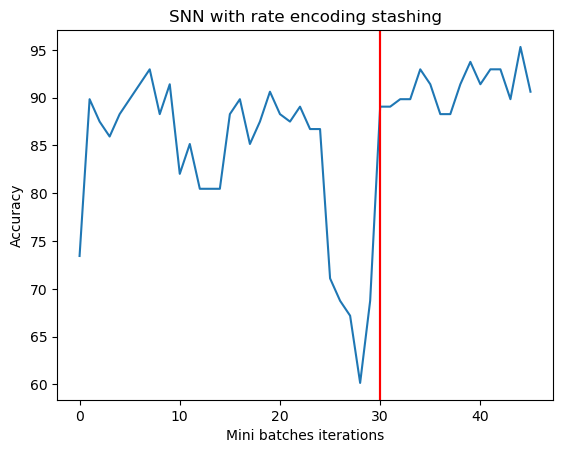

In [14]:
plt.plot(accuracy_plot)
plt.axvline(x=all_neurons_joined,color='r')
plt.title("SNN with rate encoding stashing")
plt.xlabel("Mini batches iterations")
plt.ylabel("Accuracy")
plt.axvline(x=all_neurons_joined,color='r')

In [15]:
layer1_wts = model.linear_1.weight[:,:].cpu().clone().detach().numpy()
temp_layer_1_wts = model.linear_1.weight[:,:].cpu().clone().detach().numpy()

In [16]:
spk1_freq = spk1_freq_temp[batch_size:,:]
spk1_freq = spk1_freq.cpu().detach().numpy()

Total stashed 118


(array([51.,  3.,  0.,  3.,  2.,  1.,  3.,  2.,  1., 84.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

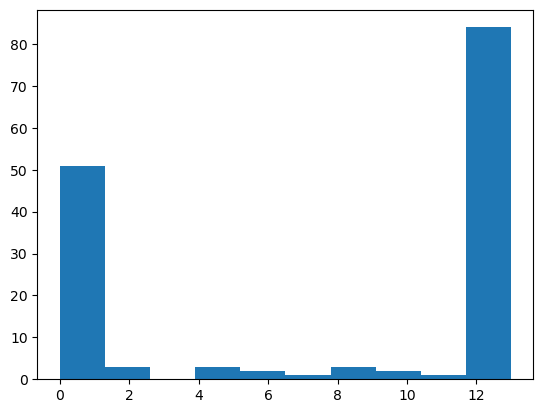

In [17]:
# Calculating the statistics of our spikes
mean_all_node = np.mean(spk1_freq,axis=0)
std_dev_all_node = np.std(spk1_freq,axis=0)
skew_all_node = skew(spk1_freq,axis=0)
successive_dif_all_node = np.diff(spk1_freq, axis=0)
print("Total stashed", len(stashed_global))
plt.hist(spk1_freq[-1,:])

Max weight value is 0.91156197
Min weight value is -0.9746297
taking avg 0.9430958032608032


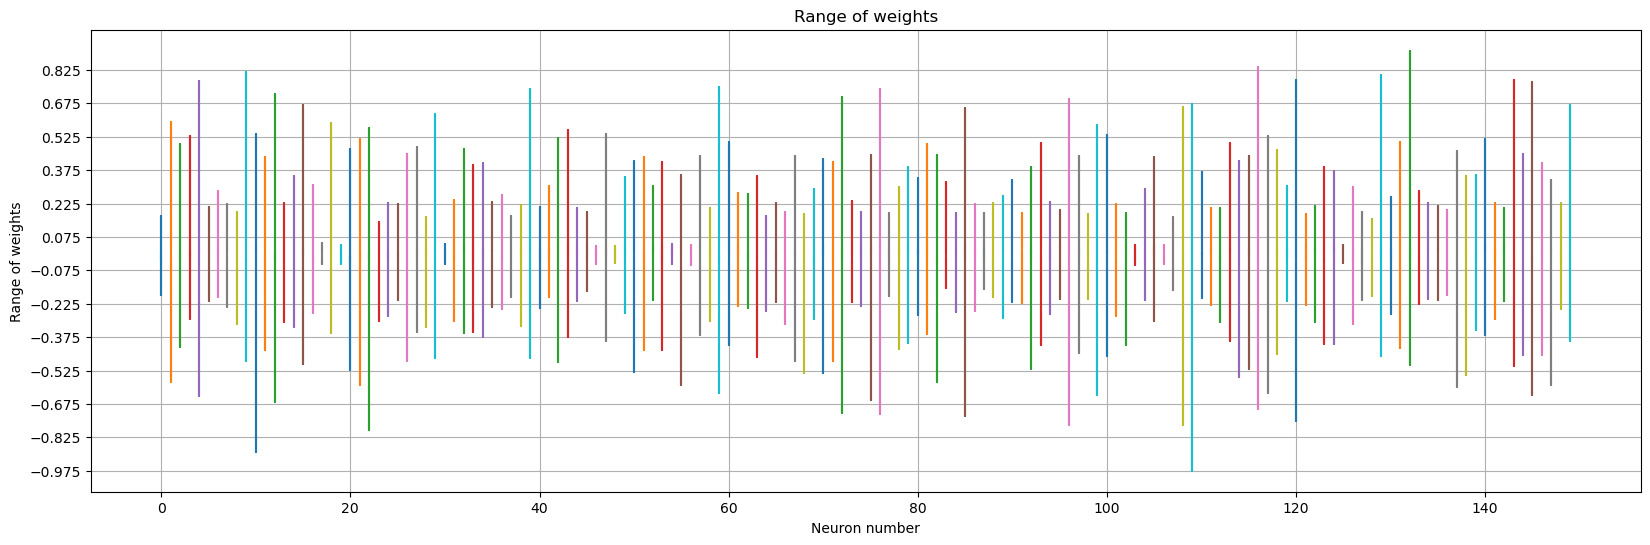

In [18]:
plt.figure(figsize=(20,6))
plt.yticks(np.arange(min(layer1_wts.flatten()),max(layer1_wts.flatten()),0.15))
for i,data in enumerate(layer1_wts):
    plt.plot([i]*len(data), data)
plt.grid()
max_wt_layer_1 = max(layer1_wts.flatten())
min_wt_layer_1 = min(layer1_wts.flatten())
avg_max_wt_layer_1 = (abs(max_wt_layer_1) + abs(min_wt_layer_1))/2
print("Max weight value is", max_wt_layer_1)
print("Min weight value is", min_wt_layer_1)
print("taking avg", avg_max_wt_layer_1)
plt.xlabel("Neuron number")
plt.ylabel("Range of weights")
plt.title("Range of weights")
plt.show()

# Quantization

In [19]:
num_of_conductance_level = 16
values_p = np.linspace(0,stop=avg_max_wt_layer_1,num=num_of_conductance_level,endpoint=True)
values_p = torch.from_numpy(values_p).to(device)
values_n = (values_p*-1)
values = torch.cat((values_n[1:], values_p))
values,_ = torch.sort(values)
values

tensor([-0.9431, -0.8802, -0.8173, -0.7545, -0.6916, -0.6287, -0.5659, -0.5030,
        -0.4401, -0.3772, -0.3144, -0.2515, -0.1886, -0.1257, -0.0629,  0.0000,
         0.0629,  0.1257,  0.1886,  0.2515,  0.3144,  0.3772,  0.4401,  0.5030,
         0.5659,  0.6287,  0.6916,  0.7545,  0.8173,  0.8802,  0.9431],
       device='cuda:0', dtype=torch.float64)

In [20]:
def closest_to(i):
    idx = torch.argmin(torch.abs(values-i))
    return(values[idx])

def quantization(layer1=True, layer2=True):
    accuracy_after_quantizing = []
    with torch.no_grad():
        if(layer1 is True):
            for i in range(len(model.linear_1.weight)):
                for j in range(len(model.linear_1.weight[0])):
                    model.linear_1.weight[i,j] = closest_to(model.linear_1.weight[i,j])
                accuracy_after_quantizing.append(accuracy())

        if(layer2 is True):
            for i in range(len(model.linear_2.weight)):
                for j in range(len(model.linear_2.weight[0])):
                    model.linear_2.weight[i,j] = closest_to(model.linear_2.weight[i,j])
                accuracy_after_quantizing.append(accuracy())
    return(accuracy_after_quantizing)      

In [21]:
layer_1_wts = copy.deepcopy(model.linear_1.weight)
layer_2_wts = copy.deepcopy(model.linear_2.weight)

Text(0, 0.5, 'Accuracy')

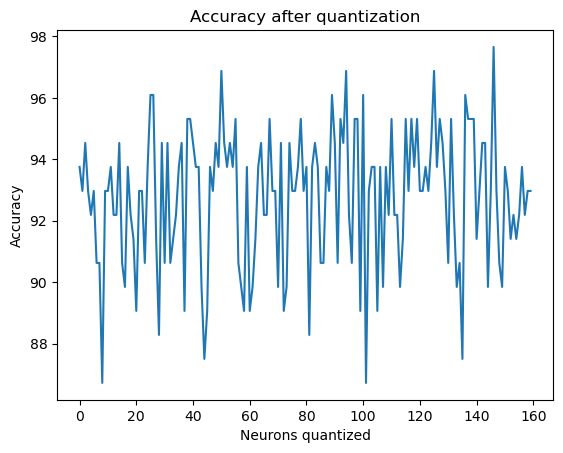

In [22]:
q = quantization()
plt.plot(q)
plt.title("Accuracy after quantization")
plt.xlabel("Neurons quantized")
plt.ylabel("Accuracy")

In [23]:
#torch.save(model, 'trial_3_thres_24_acc_87.pt')

In [24]:
# #Creating computational graph to see, whether all the neurons are contributing or not
# batch = next(iter(train_loader))
# yhat = net(batch[0].reshape(-1,28*28).to(device)) # Give dummy batch to forward().

# from torchviz import make_dot

# make_dot(yhat, params=dict(list(net.named_parameters()))).render("trial_1", format="png")